## Intro 

In this post, I'll demonstrate how to fit a Bayesian linear model using ADVI in this tutorial. Note that
the link to the repository containing this jupyter notebook is included above.

ADVI is a way of implementing variational inference without having to manually compute derivatives, 
in the presence of automatic differentiation libraries. It is typically faster, and easier to implement
than tradititional MCMC methods. While, MCMC is still considered the gold standard in Bayesian applications,
variational inference enables the exploration of many models quickly. PyTorch is a great python library 
for these types of implementations, as it supports the creation of complex computational graphs and automatic 
differentiation.

***

## Implementation

This cell contains the libraries we will need.

Note that the `torch` library is imported for automatic differentiation (AD), but any other AD library could
have been substituted with ease.

In [1]:
import torch
from torch.distributions import Normal, Gamma

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

Below, we implement a class called `ModelParam`.
You'll note that `ModelParam` holds `vp` (a tensor) and `size`, which is the dimensions of the model parameters.
At instantiation, this object creates the variational parameters -- a mean and a logged-standard deviation to a
Normal distribution. These parameters are optimized until the ELBO is maximized. The SD is logged so that 
it can be optimized in an unconstrained fashion. Recall that in ADVI, the variational distribution is placed 
on model parameters transformed to the real space. The advantages enjoyed by doing so include (1) being able
to re-parameterize the distribution so as to sample from a parameter free (standard Normal) distribution, 
to take the gradients of random draws from the variational distribution; and (2) modeling correlation
between parameters, if desired.

In [2]:
# Model parameter
class ModelParam():
    def __init__(self, size, m=None, log_s=None):
        if m is None:
            # Set the mean for the unconstrained variational distribution.
            m = torch.randn(size)

        if log_s is None:
            # Set the log standard deviation  for the unconstrained variational
            # distribution.
            log_s = torch.randn(size)

        # Variational parameters
        self.vp = torch.stack([m, log_s])
        self.vp.requires_grad = True

        # Dimension of the variational parameters
        self.size = size

    def dist(self):
        # Unconstrained variational distribution -- a Gaussian always.
        # NOTE: If the parameter (theta) of interest has positive support,
        #       we place a Normal variational distribution on log(theta).
        return torch.distributions.Normal(self.vp[0], self.vp[1].exp())

    def rsample(self, n=torch.Size([])):
        # NOTE: The same as:
        # self.vp[0] + torch.randn(n) * self.vp[1].exp()
        # Note that the random number is sampled from a (parameter-free)
        # standard normal.
        return self.dist().rsample(n)

    def log_q(self, real):
        # log variational density of parameter, evaluated on unonstrained
        # space.
        return self.dist().log_prob(real).sum()



The linear model is:

$$
\begin{aligned}
y_i \mid \sigma, \beta &\sim \text{Normal}(\beta_0 + \beta_1 x_i, \sigma), \text{ for } i = 1,\cdots, N\\
\beta_k &\sim \text{Normal}(0, 1), \text{ for } k = 0, 1 \\
\sigma &\sim \text{Gamma}(1, 1). \\
\end{aligned}
$$

We encode this in the following cells. Note that we need to implement

1. log-likelihood
3. the log of the prior density times absolute value of the determinant of the jacobian (since we are transforming the parameters onto the real scale)
2. the log of the variational density (evaluated at the parameters sampled from the variational distribution)
4. the elbo, which is done as follows:
    - sample model parameters (on the real scale) from the variational distributions
        - recall that to obtain parameter-samples, we first draw from a standard Normal, 
          and then multiply the sd of the variational parameter to the standard Normal, 
          and then add the variational parameter's mean.
    - transform the real-valued parameters to their support (in this case only sigma needs to be exponentiated).
    - Evaluate: ELBO = (1) + (2) - (3)

One more thing to note here is that I multiplied the likelihood by the size of the full data, and divided by the size of the
current data (hence the `mean(0)` in the return line of `loglike`). This enables stochastic variational inference, in
which minibatches are employed. This can lead to huge speed-ups when analyzing large data-sets.

In [3]:
def log_prior_plus_logabsdet_J(real_params, params):
    # log prior for beta, evaluated at sampled values for beta
    lp_b = Normal(0, 1).log_prob(real_params['beta']).sum()

    # log prior sig + log jacobian
    lp_log_sig = (Gamma(1, 1).log_prob(params['sig']) + real_params['sig']).sum()

    return lp_b + lp_log_sig

def loglike(y, x, params, full_data_size):
    beta = params['beta']
    sig = params['sig']
    return Normal(x.matmul(beta), sig).log_prob(y).mean(0) * full_data_size

def log_q(model_params, real_params):
    out = 0.0
    for key in model_params:
        out += model_params[key].log_q(real_params[key])
    return out

def elbo(y, x, model_params, full_data_size):
    real_params = {}
    for key in model_params:
        real_params[key] = model_params[key].rsample()

    params = {'beta': real_params['beta'],
              'sig': real_params['sig'].exp()}

    out = loglike(y, x, params, full_data_size)
    out += log_prior_plus_logabsdet_J(real_params, params) 
    out -= log_q(model_params, real_params)

    return out

Now, we are ready to fit the model. For reproducibility, I will set seeds for the random number generators.

In [4]:
# set random number generator seeds for reproducibility
torch.manual_seed(1)
np.random.seed(0)

We now generate some data. We will use 1000 samples. Note that the true values of the parameters are 
$\beta = (2, -3)$ and $\sigma = 0.5$. I've included a plot of the data.

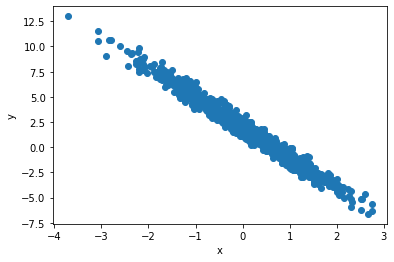

In [5]:
# Generate data
N = 1000
x = torch.stack([torch.ones(N), torch.randn(N)], -1)
k = x.shape[1]
beta = torch.tensor([2., -3.])
sig = 0.5
y = Normal(x.matmul(beta), sig).rsample()

# Plot data
plt.scatter(x[:, 1].numpy(), y.numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

The model is fit in this cell. We first define the model parameters in `model_params` in a dictionary.
All only need to specify the size for the initialization, the initial values for the variational parameters are drawn from a standard normal.
Recall that the variational parameters are the mean and SD of the Normal, but the SD is stored as the logged SD in the class.

We use the Adam optimizer with a learning rate of 0.1. This may seem large, but we will see that it is not.

We do Stochastic gradient descent (SGD) for 1000 iterations. Each iteration, we subsample 100 observations from the original data.
We compute the loss (as torch minimizes objectives) by computing the negative of the elbo divided by the size of the full data ($N$).
Dividing the elbo by $N$ allows us to use a larger learning rate (`lr`). This is not a huge deal, but most of the time, I can
just use a default learning rate of 0.1 by scaling the ELBO.

You need to manually set the gradients to zero before computing the gradients (in `loss.backward()`, as the default behavior 
of the library is to accumulate gradients. `loss.backward()` signals the gradient computation. `optimizer.step()` signals
the modification of the (variational) parameters based on the gradients.

I print out statements to show the progression of the model fitting. As you can see, it takes only a few second to get decent results.

In [6]:
model_params = {'beta': ModelParam(size=k), 'sig': ModelParam(size=1)}
optimizer = torch.optim.Adam([model_params[key].vp for key in model_params], lr=.1)
elbo_hist = []

max_iter = 3000
minibatch_size = 100
torch.manual_seed(1)

# This basically creates a progress bar for SGD. max_iter determines the final iteration.
# mininterval determines how often the progress bar is updated (every 1 second here).
iters = trange(max_iter, mininterval=1)

# Stochastic gradient descent
for t in iters:
    sample_with_replacement = minibatch_size > N
    idx = np.random.choice(N, minibatch_size, replace=sample_with_replacement)
    loss = -elbo(y[idx], x[idx, :], model_params, full_data_size=N) / N
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress bar
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

ELBO: -0.8149844798486972: 100%|██████████| 3000/3000 [00:11<00:00, 261.55it/s]


We plot the elbo history, which seems to indicate convergence.

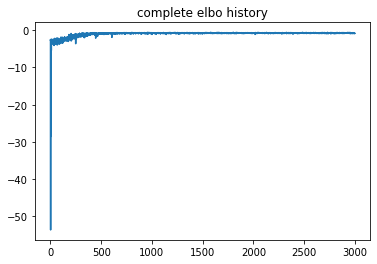

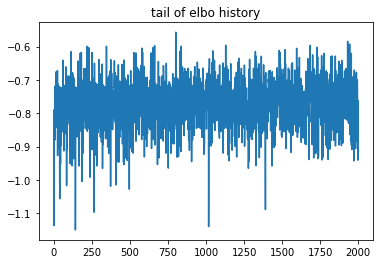

In [7]:
# Plot ELBO history
plt.plot(elbo_hist)
plt.title('complete elbo history')
plt.show()

# Plot ELBO history (after 100-th iteration)
plt.plot(elbo_hist[1000:])
plt.title('tail of elbo history')
plt.show()

We inspect the statistics of the posterior in this cell.
The posterior mean and SD are printed. They are consistent with the true values.


In [8]:
# Inspect posterior
nsamps = 1000
sig_post = model_params['sig'].rsample([nsamps]).exp().detach().numpy()
print('True beta: {}'.format(beta.detach().numpy()))
print('beta mean: {}'.format(model_params['beta'].vp[0].detach().numpy()))
print('beta sd: {}'.format(model_params['beta'].vp[1].exp().detach().numpy()))
print()

print('True sigma: {}'.format(sig))
print('sig mean: {} | sig sd: {}'.format(sig_post.mean(), sig_post.std()))

True beta: [ 2. -3.]
beta mean: [ 1.99261658 -3.08685975]
beta sd: [0.02348985 0.01433441]

True sigma: 0.5
sig mean: 0.5246807576382299 | sig sd: 0.025474909031553427


This concludes this tutorial. I hope you found it useful. I will be posting a few more examples, including

- Logistic regression
- Gaussian mixture models (and how to get cluster membership)
- handling missing values